#  Прогнозирование заказов такси

Исследование для компании «N такси».

`Цель:` привлекать больше водителей в период пиковой нагрузки.

`Задача:` построить модель, прогнозирующую количество заказов такси на следующий час.

`План работ:`
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

- Метрика: RMSE.
- Порог:  на тестовой выборке <= 48.


`Входные данные:`  исторические данные о заказах такси в аэропортах, файл taxi.csv.

- Дата заказа `datetime`.
- Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).



### Подключение библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import warnings
# Игнорирование предупреждений
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose

import catboost
from catboost import CatBoostRegressor
import lightgbm as ltb

In [2]:
def rmse(y,a):
    return mse(y,a)**0.5

## Подготовка

### Загрузка и основная информация о данных

Признак даты сделаем индексом, тем самым преобразовали датафрейм во временной ряд.

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [4]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
print(taxi.index.is_monotonic)

True


Значения индекса расположены в хронологическом порядке.

In [6]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [7]:
#taxi = taxi.sort_index()

In [8]:
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [9]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [11]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

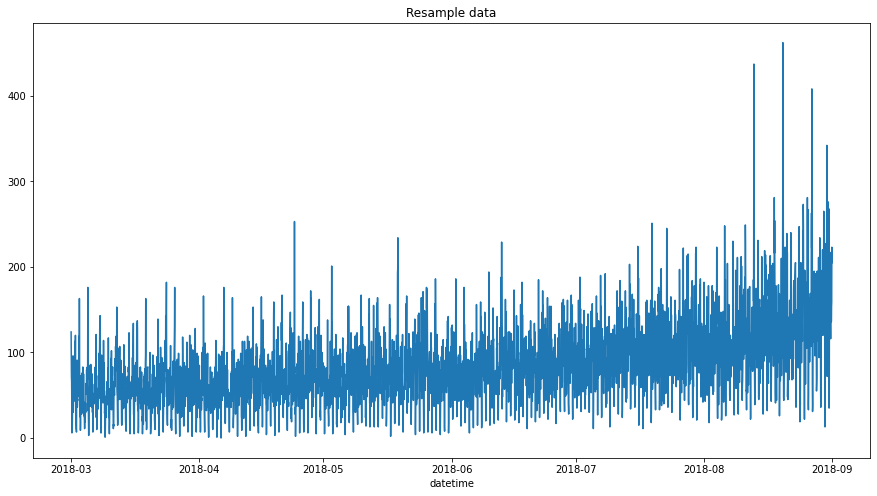

In [12]:
taxi = taxi.resample('1H').sum()
plt.figure(figsize=(15,8))
plt.plot(taxi)
plt.xlabel('datetime')
plt.title('Resample data')
plt.show()

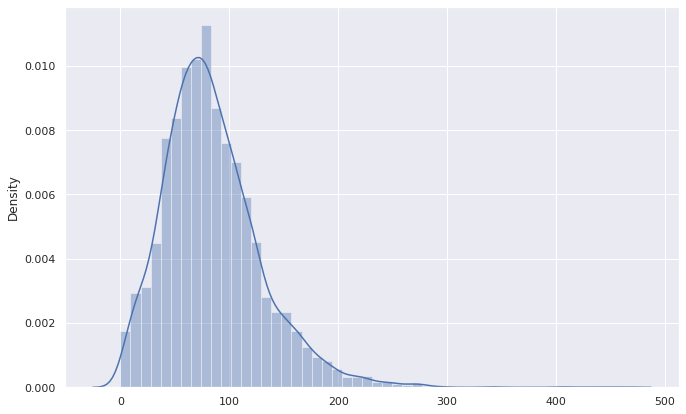

In [13]:
sns.set(rc={'figure.figsize':(11,7)})
sns.distplot(taxi);

Одномодальное распределение с положительный коэф. аасиметрии.


## Анализ

### Скользящее среднее

Сгладим временной ряд.

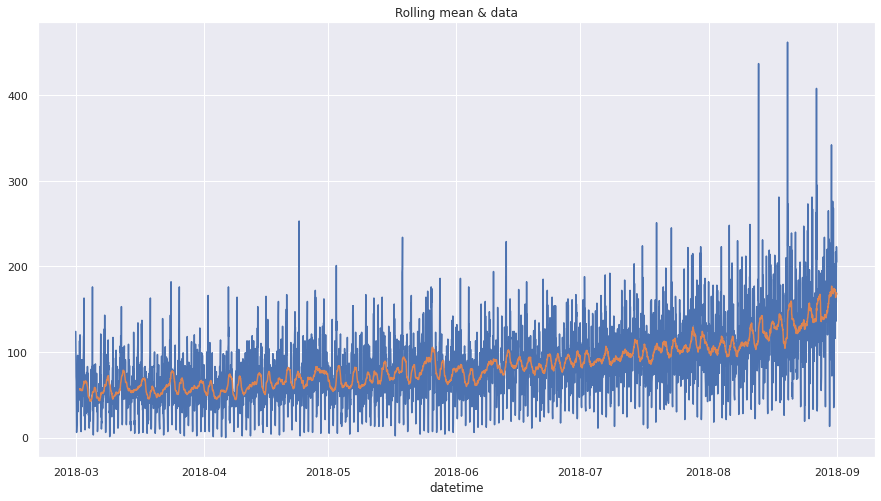

In [14]:
taxi['rolling_mean'] = taxi.rolling(24).mean()
plt.figure(figsize=(15,8))
plt.plot(taxi)
plt.xlabel('datetime')
plt.title('Rolling mean & data')
plt.show()

Чтобы декомпозировать данные, необходимо заполнить пропуски

In [15]:
taxi.isnull().sum()

num_orders       0
rolling_mean    23
dtype: int64

In [16]:
taxi['rolling_mean'] = taxi['rolling_mean'].fillna(0)
taxi.isnull().sum()

num_orders      0
rolling_mean    0
dtype: int64

### Декомпозиция

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

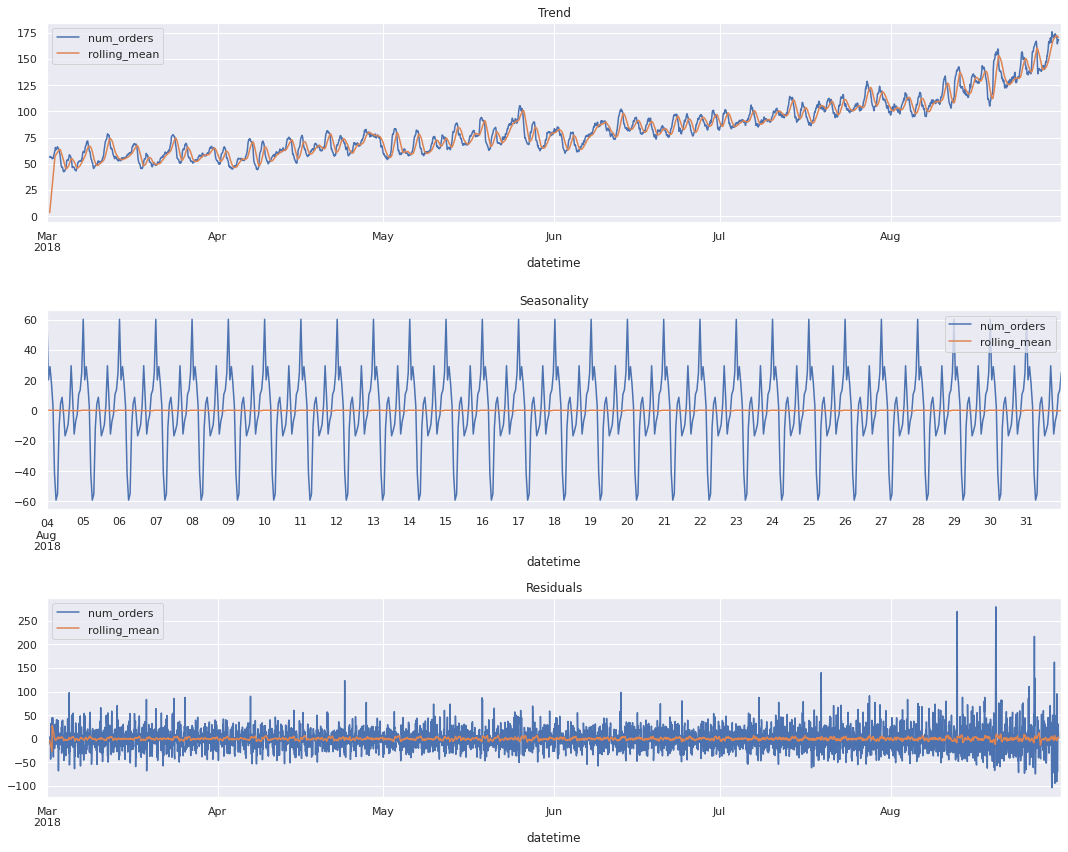

In [17]:
decomposed_taxi = seasonal_decompose(taxi['num_orders'])
decomposed_taxi_rolling = seasonal_decompose(taxi['rolling_mean'])

plt.figure(figsize=(15, 12))
plt.subplot(311)

decomposed_taxi.trend.plot(ax=plt.gca(),label='num_orders')
decomposed_taxi_rolling.trend.plot(ax=plt.gca(),label='rolling_mean')
plt.legend()

plt.title('Trend')
plt.subplot(312)


decomposed_taxi.seasonal.tail(24*7*4).plot(ax=plt.gca(),label='num_orders')
decomposed_taxi_rolling.seasonal.tail(24*7*4).plot(ax=plt.gca(),label='rolling_mean')
plt.legend()

plt.title('Seasonality')
plt.subplot(313)


decomposed_taxi.resid.plot(ax=plt.gca(),label='num_orders')
decomposed_taxi_rolling.resid.plot(ax=plt.gca(),label='rolling_mean')
plt.legend()

plt.title('Residuals')
plt.tight_layout()


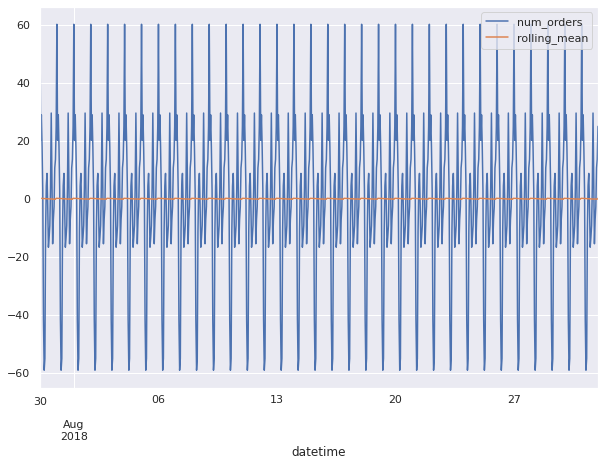

In [18]:
plt.figure(figsize=(10, 7))
decomposed_taxi.seasonal['2018-07-30':'2018-08-31'].plot(ax=plt.gca(),label='num_orders')
decomposed_taxi_rolling.seasonal['2018-07-30':'2018-08-31'].plot(ax=plt.gca(),label='rolling_mean')
plt.legend();

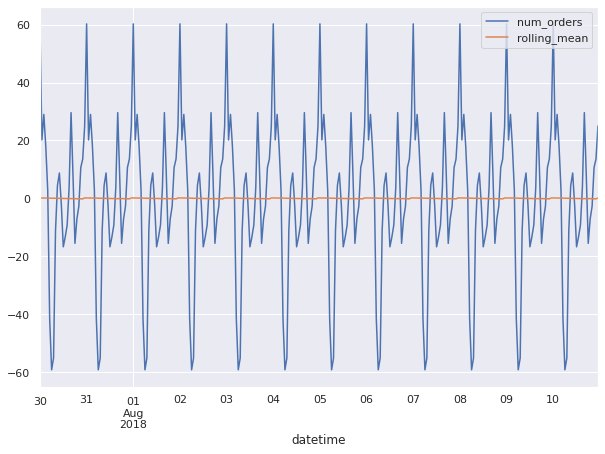

In [19]:
plt.figure(figsize=(10, 7))
decomposed_taxi.seasonal['2018-07-30':'2018-08-10'].plot(ax=plt.gca(),label='num_orders')
decomposed_taxi_rolling.seasonal['2018-07-30':'2018-08-10'].plot(ax=plt.gca(),label='rolling_mean')
plt.legend();

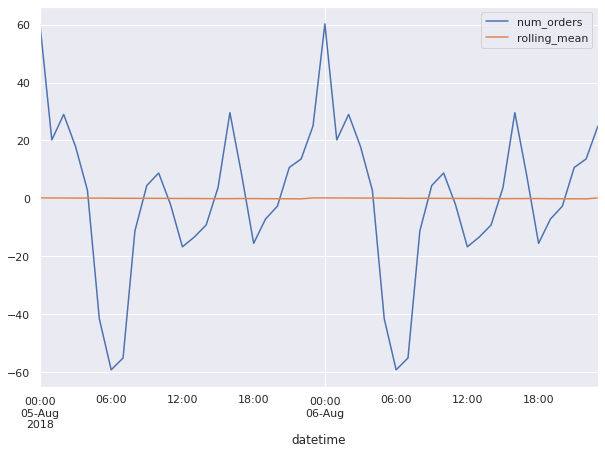

In [20]:
plt.figure(figsize=(10, 7))
decomposed_taxi.seasonal['2018-08-05':'2018-08-06'].plot(ax=plt.gca(),label='num_orders')
decomposed_taxi_rolling.seasonal['2018-08-05':'2018-08-06'].plot(ax=plt.gca(),label='rolling_mean')
plt.legend();

##### Вывод:

Общий тренд на рост.

Сезонность:  
1)дневная сезонность неявная или отсутствует  
2)Но ведь есть ещё внутрисуточная сезонность: положительный пик в 00:00, отрицательный пик в 06:00  
3)Месячную сезоность не выделить , тк данные за один год  



## Обучение

### Создание признаков

In [21]:
def make_features(data, max_lag):
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [22]:
make_features(taxi,2)

In [23]:
taxi.head(100)

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2
datetime,,,,,,
2018-03-01 00:00:00,124,0.000000,0,3,NaN,NaN
2018-03-01 01:00:00,85,0.000000,1,3,124.0,NaN
2018-03-01 02:00:00,71,0.000000,2,3,85.0,124.0
2018-03-01 03:00:00,66,0.000000,3,3,71.0,85.0
2018-03-01 04:00:00,43,0.000000,4,3,66.0,71.0
...,...,...,...,...,...,...
2018-03-04 23:00:00,68,47.541667,23,6,83.0,75.0
2018-03-05 00:00:00,86,48.000000,0,0,68.0,83.0
2018-03-05 01:00:00,176,52.833333,1,0,86.0,68.0


### Разделение данных
Разделим данные указав параметр shaffle = False

In [24]:
train, valid = train_test_split(taxi, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

train = train.dropna()

In [25]:
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

features_valid = valid.drop(columns=['num_orders'])
target_valid = valid['num_orders']

features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']


In [26]:
target_valid

datetime
2018-07-26 04:00:00    131
2018-07-26 05:00:00     83
2018-07-26 06:00:00     21
2018-07-26 07:00:00     39
2018-07-26 08:00:00     80
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 442, dtype: int64

### Обучение моделей

#### LinearRegression

In [27]:
linear_reg_model = LinearRegression().fit(features_train,target_train)

In [28]:
linear_reg_results = rmse(target_valid,linear_reg_model.predict(features_valid))
linear_reg_results

40.792180284828625

#### RandomForestRegressor

In [29]:
rfr = RandomForestRegressor(random_state=420,criterion='mse')

In [77]:
param_grid = {"n_estimators": [1,15],
             'max_depth' : [8,9,10,11,12]}

In [78]:
tscv = TimeSeriesSplit(n_splits=24) #надо посмотерть, как подобрать параметр и аргументировать
grid = GridSearchCV(rfr, param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(features_train, target_train)
grid.best_estimator_

RandomForestRegressor(max_depth=12, n_estimators=15, random_state=420)

In [79]:
# RMSE
forrest_results = abs(grid.best_score_) **0.5
forrest_results

22.364988777730925

In [80]:
forrest = grid.best_estimator_

#### CatBoostRegressor

In [34]:
cat_model = CatBoostRegressor(loss_function='RMSE', iterations=80, random_state=420,learning_rate=0.5)


cat_model.fit(features_train, 
              target_train, 
              #eval_set=[features_valid,target_valid],
              verbose=10,
              plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 28.6118552	total: 48ms	remaining: 3.79s
10:	learn: 20.4025972	total: 58.8ms	remaining: 369ms
20:	learn: 18.9137820	total: 69.1ms	remaining: 194ms
30:	learn: 17.7426999	total: 79.6ms	remaining: 126ms
40:	learn: 16.9391039	total: 89.8ms	remaining: 85.4ms
50:	learn: 16.2933472	total: 99.8ms	remaining: 56.7ms
60:	learn: 15.6743216	total: 110ms	remaining: 34.2ms
70:	learn: 15.2822004	total: 120ms	remaining: 15.2ms
79:	learn: 14.8519411	total: 130ms	remaining: 0us


In [35]:
cat_model_results = rmse(target_valid,cat_model.predict(features_valid))

#### LGBMRegressor

In [36]:
lgbm = ltb.LGBMRegressor(num_leaves=30, learning_rate=0.05, n_estimators=20, random_state=420)
lgbm.fit(features_train, target_train)
predict_lgbm = pd.DataFrame(lgbm.predict(features_valid))

lgbm_model_results = rmse(target_valid,predict_lgbm)
lgbm_model_results

39.512311645322505

In [37]:
result_models = {'LinearRegression':[linear_reg_results],
                 'CatBoostRegressor':[cat_model_results],
                 'LGBMRegressor':[lgbm_model_results],
                 'RandomForestRegressor':[forrest_results]}
results = pd.DataFrame(result_models)
results

,LinearRegression,CatBoostRegressor,LGBMRegressor,RandomForestRegressor
0,40.79218,29.871741,39.512312,22.127241


#### Вывод: на валидационных данных наилучшее качество RandomForestRegressor

## Тестирование

Протестируем модели на тестовых данных

In [82]:
model_list = [cat_model,lgbm,forrest,linear_reg_model]
for model in model_list:
    print(model)
    print(rmse(target_test,model.predict(features_test)))
    print()

52.16666212214675

LGBMRegressor(learning_rate=0.05, n_estimators=20, num_leaves=30,
              random_state=420)
65.82383616885741

RandomForestRegressor(max_depth=12, n_estimators=15, random_state=420)
46.16727502097292

LinearRegression()
50.8094305473242



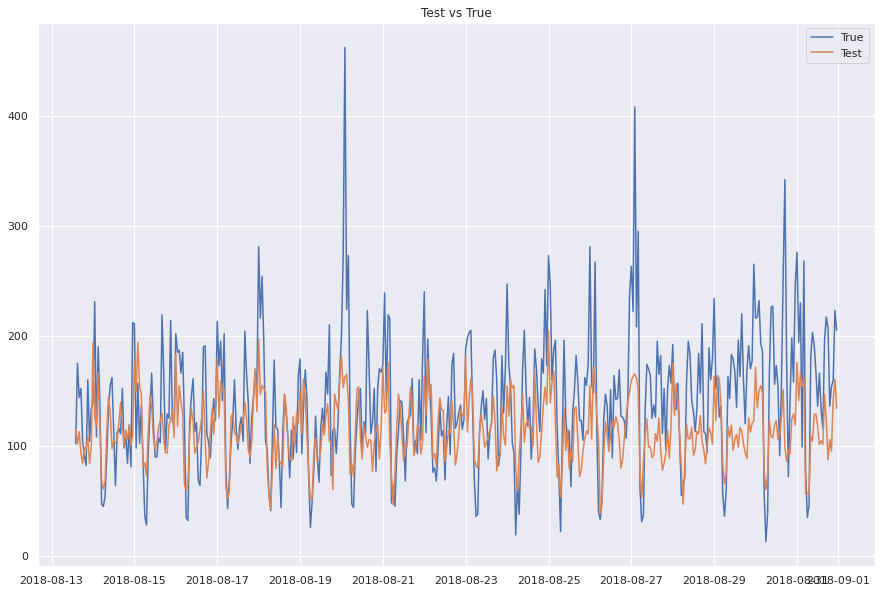

In [39]:
plt.figure(figsize=(15,10))

plt.plot(target_test,label='True')
plt.plot(target_test.index,cat_model.predict(features_test),label='Test')
plt.title('Test vs True')
plt.legend()
plt.show()

## Вывод:

1. Загружены данные и ресемплированы по одному часу.
2. Данные проанализировать.
3. Обучены разные модели с различными гиперпараметрами. 
4. Данные проверены на тестовой выборке.
5. Выбрана модель RandomForestRegressor(max_depth=12, n_estimators=15, random_state=420)
6. Достигнутое значение метрики RMSE на тестовой выборке: 46.167

